### Setup parameters, functions etc.

# Assumptions

 * RPI = fixed 2.4%
 * CPI = fixed at 1.9%
 * Salaries and salary-based thresholds increase with CPI
 * Loan interest charged at RPI below £25725, RPI+3% above £46305, linearly scaled between the two
 
### Salaries:
**Low salary profile**: Starts at £20k, Rises £750/yr (+ inflation), capped at £30k (in 2019 £)

**Average salary profile**: Starts at £25k, Rises £1k/year (+ inflation), capped at £45k (in 2019 £)

**High salary profile**: Starts at £25k, Rises £2k/year (+ inflation), capped at £60k (in 2019 £)

**Very High salary profile**: Starts at £30k, Rises £2k/year (+ inflation), uncapped

**Extremely high salary proile**: Starts at £30k, doubles each decade (+ inflation), uncapped

**Super-rich**: Starta at £50k, doubles each decade (+ inflation), uncapped


### Pre-Augar
 * Repayments charged at 9% of earnings above £25750
 * Interest pre-graduation = RPI + 3%
 * Repayments for 30 years
 * Fee = £9250/yr (for 3 years)
 * Subsistence = £5000/yr (for 3 years)
 
### Post=Augar
 * Repayments charged at 9% of earnings above £23000
 * Interest pre-graduation = RPI
 * Repayments for 40 years
 * Max loan = 1.2 * original loan (+ inflation)
 * Fee = £7250/yr (for 3 years)
 * Subsistence = £3000/yr (for 3 years)


In [1]:
#import modules
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.cm as cmap

def addLoan(year=0,augar=False):
    if augar:
        # numbers in Auguer review
        fees_yr=7250
        subsistence_yr=3000
        maxYrRepay=40
    else:
        # numbers pre-Auguer review
        fees_yr=9250
        subsistence_yr=5000
    if year<0:
        return fees_yr + subsistence_yr
    else:
        return 0

def getLoanInterest(salary,year,rpi=0.024,cpi=0.019,augar=False,gradTax=False):
    
    if augar:
        # lowest interest rate
        lim0=25725 * (1+cpi)**year
        # highest interest rate
        lim1=46305 * (1+cpi)**year
        # max increase above rpi
        maxinc=0.03
        # interest while studying
        studyint=rpi
        timelim=40
    else:
        lim0=25725 * (1+cpi)**year
        lim1=46305 * (1+cpi)**year
        maxinc=0.03
        studyint=rpi+maxinc
        timelim=30
    if year<0:
        # still studying
        interest=studyint
    elif year>=timelim and gradTax==False:
        # loan is wiped out
        interest=-1
    elif salary < lim0:
        # below threshold 1
        interest=rpi
    elif salary >=lim1:
        # below threshold 2
        interest=rpi+maxinc
    else:
        # between thresholds
        interest = rpi + maxinc * (salary-lim0)/(lim1-lim0)
    return interest

def getLoanRepayment(salary,year,cpi=0.019,gradTax=False,augar=False):
    if augar:
        # repayment threshold
        lim0=23000 * (1+cpi)**year
        # repayment rate
        rate=0.09
        # set repayment timelimit
        timelim=40
    else:
        lim0=25750 * (1+cpi)**year
        rate=0.09
        timelim=30
    if year <0:
        repay=0
    elif year>timelim and gradTax==False:
        # over time limit. no repayment
        repay=0
    elif salary<=lim0:
        # salary bewlow threshold. no repayment
        repay=0
    else:
        # repay at <rate> on salary above <lim0>
        repay = rate * (salary-lim0)
    return(repay)

def removeInflation(costIn,years=[],inflation=0.19):
    if len(years)==0:
        years=arange(len(costIn))
    costOut=np.zeros_like(costIn)
    for y in range(len(years)):
        costOut[y]=costIn[y] / (1+inflation)**years[y]
    return costOut

# set salary profiles parameters
def getSalary(year,name,interest=0.019):
    if name=='avg':
        salary=25000 + 1000*year
        salary=np.min([45000,salary])
    elif name=='low':
        salary=20000 + 750*year
        salary=np.min([30000,salary])
    elif name=='high':
        salary=25000 + 2000*year
        salary=np.min([60000,salary])
    elif name=='vhigh':
        salary=30000 + 2000*year
    elif name=='exhigh':
        salary=30000 * 2**(year/10)
    elif name=='superrich':
        salary=50000 * 2**(year/10)
    else:
        salary=int(name.split('k')[0])*1000
    
    #apply interest
    salary = salary * (1+interest)**year
    if year <0:
        return 0
    else:
        return salary

# function to compute repayments
def calcRepayments(dataIn,cpi=0.019,rpi=0.024,gradTax=False,auger=False):
    if not 'year' in dataIn:
        dataIn['year']=np.arange(-3,40)
    if not 'salary' in dataIn:
        dataIn['salary']=np.zeros_like(dataIn['year'])
        for y in range(len(dataIn['year'])):
            dataIn['salary'][y]=getSalary(dataIn['year'][y],dataIn['profile'])
    dataIn['loan']=np.zeros_like(dataIn['year'])
    dataIn['interest']=np.zeros_like(dataIn['year'])
    dataIn['repayment']=np.zeros_like(dataIn['year'])
    dataIn['repayment-total']=np.zeros_like(dataIn['year'])
    dataIn['original_loan']=np.zeros_like(dataIn['year'])
    dataIn['frac-repaid']=np.zeros_like(dataIn['year'])
    
    dataIn['loan_augar']=np.zeros_like(dataIn['year'])
    dataIn['maxloan_augar']=np.zeros_like(dataIn['year'])
    dataIn['interest_augar']=np.zeros_like(dataIn['year'])
    dataIn['repayment_augar']=np.zeros_like(dataIn['year'])
    dataIn['repayment-total_augar']=np.zeros_like(dataIn['year'])
    dataIn['original_loan_augar']=np.zeros_like(dataIn['year'])
    dataIn['frac-repaid_augar']=np.zeros_like(dataIn['year'])
    
    dataIn['total_repayment']=0
    dataIn['total_repayment_augar']=0
    
    for y in range(len(dataIn['year'])):
        year=dataIn['year'][y]
        if p=='high' and y<10:
            verbose=False
        else:
            verbose=False
        if verbose:
            print('--- {} ---'.format(year))
        if y==0:
            # add first value
            dataIn['loan'][y]=addLoan(year,augar=False)
            dataIn['loan_augar'][y]=addLoan(year,augar=True)
            if verbose:print('first add:',addLoan(year,augar=True),'=',dataIn['loan_augar'][y])
        else:
            # take off repayment from previous year
            dataIn['loan'][y] = dataIn['loan'][y-1] - dataIn['repayment'][y-1]
            dataIn['loan_augar'][y] = dataIn['loan_augar'][y-1] - dataIn['repayment_augar'][y-1]
            if verbose:
                print('repaying:',dataIn['loan_augar'][y-1],'-',dataIn['repayment_augar'][y-1],'=',dataIn['loan_augar'][y])
            # add to loan (only while studying)
            dataIn['loan'][y] += addLoan(year,augar=False)
            dataIn['loan_augar'][y] += addLoan(year,augar=True)
            if verbose:print('adding to loan:',addLoan(year,augar=True),'=',dataIn['loan_augar'][y])     
        
        
        # cap at 1.2* original loan + inflation
        dataIn['maxloan_augar'][y] = 1.2 * dataIn['original_loan_augar'][y]
            
        if dataIn['loan'][y]>0:
            # add on interest
            dataIn['interest'][y] = dataIn['loan'][y] * getLoanInterest(dataIn['salary'][y],year,augar=False)
            dataIn['loan'][y] += dataIn['interest'][y]
            if y>0:
                # add  interest to original loan
                dataIn['original_loan'][y] = dataIn['original_loan'][y-1] * (1+cpi)
            # add to original loan (while studying)
            dataIn['original_loan'][y] += addLoan(year,augar=False)
        else:
            # don't add to original loan
            dataIn['original_loan'][y] = dataIn['original_loan'][y-1]
        
        if dataIn['loan_augar'][y]>0:
            # add on interest
            dataIn['interest_augar'][y] = dataIn['loan_augar'][y] * getLoanInterest(dataIn['salary'][y],year,augar=True)
            if verbose:
                print('interest on',dataIn['loan_augar'][y],'=',getLoanInterest(dataIn['salary'][y],year,augar=True),'=',dataIn['interest_augar'][y])
            dataIn['loan_augar'][y] += dataIn['interest_augar'][y]
            if verbose:
                print('adding interest',dataIn['interest_augar'][y],'=',dataIn['loan_augar'][y])

            if y>0:
                # add  interest to original loan
                dataIn['original_loan_augar'][y] = dataIn['original_loan_augar'][y-1] * (1+cpi)
            # add to original loan (while studying)
            dataIn['original_loan_augar'][y] += addLoan(year,augar=True)
            dataIn['maxloan_augar'][y]=1.2*dataIn['original_loan_augar'][y]
            if year>0:
                if verbose:
                    print('max loan:',dataIn['maxloan_augar'][y])
                dataIn['loan_augar'][y] = np.min([dataIn['loan_augar'][y],dataIn['maxloan_augar'][y]])
        else:
            dataIn['original_loan_augar'][y] = dataIn['original_loan_augar'][y-1]
            dataIn['maxloan_augar'][y] = dataIn['maxloan_augar'][y-1] * (1+cpi)
            if verbose:
                    print('max loan:',dataIn['maxloan_augar'][y])
            
        # calculate new repayment
        dataIn['repayment'][y] = getLoanRepayment(dataIn['salary'][y],year,augar=False)
        dataIn['repayment'][y] = np.min([dataIn['repayment'][y],dataIn['loan'][y]])
        dataIn['repayment_augar'][y] = getLoanRepayment(dataIn['salary'][y],year,augar=True)
        dataIn['repayment_augar'][y] = np.min([dataIn['repayment_augar'][y],dataIn['loan_augar'][y]])
        if verbose:
            print('repayment from',dataIn['salary'][y],'=',dataIn['repayment_augar'][y])
            
        
        dataIn['total_repayment'] += dataIn['repayment'][y]
        dataIn['total_repayment_augar'] += dataIn['repayment_augar'][y]
        if verbose:
            print('total_repayment',dataIn['total_repayment_augar'])
        
        # calculate total repayments to date
        dataIn['repayment-total'][y] = dataIn['total_repayment']
        dataIn['repayment-total_augar'][y] = dataIn['total_repayment_augar']
        
    # convert to inflation-free quantities
    dataIn['salary-noinf'] = removeInflation(dataIn['salary'],dataIn['year'],inflation=cpi)
    dataIn['loan-noinf'] = removeInflation(dataIn['loan'],dataIn['year'],inflation=cpi)
    dataIn['interest-noinf'] = removeInflation(dataIn['interest'],dataIn['year'],inflation=cpi)
    dataIn['repayment-noinf'] = removeInflation(dataIn['repayment'],dataIn['year'],inflation=cpi)
    dataIn['effectiveTax'] = dataIn['repayment'] / dataIn['salary']
    dataIn['frac-repaid'] = dataIn['repayment-total']/dataIn['original_loan']
    #
    dataIn['loan-noinf_augar'] = removeInflation(dataIn['loan_augar'],dataIn['year'],inflation=cpi)
    dataIn['maxloan-noinf_augar'] = removeInflation(dataIn['maxloan_augar'],dataIn['year'],inflation=cpi)
    dataIn['interest-noinf_augar'] = removeInflation(dataIn['interest_augar'],dataIn['year'],inflation=cpi)
    dataIn['repayment-noinf_augar'] = removeInflation(dataIn['repayment_augar'],dataIn['year'],inflation=cpi)
    dataIn['effectiveTax_augar'] = dataIn['repayment_augar'] / dataIn['salary']
    dataIn['frac-repaid_augar'] = dataIn['repayment-total_augar']/dataIn['original_loan_augar']
    #
    dataIn['avgSalary'] = np.mean(dataIn['salary'])
    dataIn['totalSalary'] = np.mean(dataIn['salary'])
    return dataIn

### Compute values

In [2]:
colmap= cmap.get_cmap('jet')

data={'avg':{'profile':'avg','col':'k','gradTax':False,'desc':'Average salary profile','type':'profile'},
      'low':{'profile':'low','col':'g','gradTax':False,'desc':'Low salary profile','type':'profile'},
      'high':{'profile':'high','col':'b','gradTax':False,'desc':'High salary profile','type':'profile'},
      'vhigh':{'profile':'vhigh','col':'r','gradTax':False,'desc':'Very high salary profile','type':'profile'},
      'exhigh':{'profile':'exhigh','col':'m','gradTax':False,'desc':'Extremely high salary profile','type':'profile'},
      'superrich':{'profile':'superrich','col':'orange','gradTax':False,'desc':'Super-rich','type':'profile'},
      '25k':{'profile':'25k','col':colmap(0.1),'gradTax':False,'desc':'£25k flat','type':'flat'},
      '30k':{'profile':'30k','col':colmap(0.2),'gradTax':False,'desc':'£30k flat','type':'flat'},
      '35k':{'profile':'35k','col':colmap(0.3),'gradTax':False,'desc':'£35k flat','type':'flat'},
      '40k':{'profile':'40k','col':colmap(0.4),'gradTax':False,'desc':'£40k flat','type':'flat'},
      '45k':{'profile':'45k','col':colmap(0.5),'gradTax':False,'desc':'£45k flat','type':'flat'},
      '50k':{'profile':'50k','col':colmap(0.6),'gradTax':False,'desc':'£50k flat','type':'flat'},
      '55k':{'profile':'55k','col':colmap(0.7),'gradTax':False,'desc':'£55k flat','type':'flat'},
      '60k':{'profile':'60k','col':colmap(0.8),'gradTax':False,'desc':'£60k flat','type':'flat'},
      '100k':{'profile':'100k','col':colmap(0.9),'gradTax':False,'desc':'£100k flat','type':'flat'},
      '150k':{'profile':'150k','col':colmap(1.0),'gradTax':False,'desc':'£150k flat','type':'flat'},
     }
for p in data:
    data[p]=calcRepayments(data[p],gradTax=data[p].get('gradTax',False))

/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:231: RuntimeWarning: invalid value encountered in true_divide
/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:238: RuntimeWarning: invalid value encountered in true_divide


### Make plots

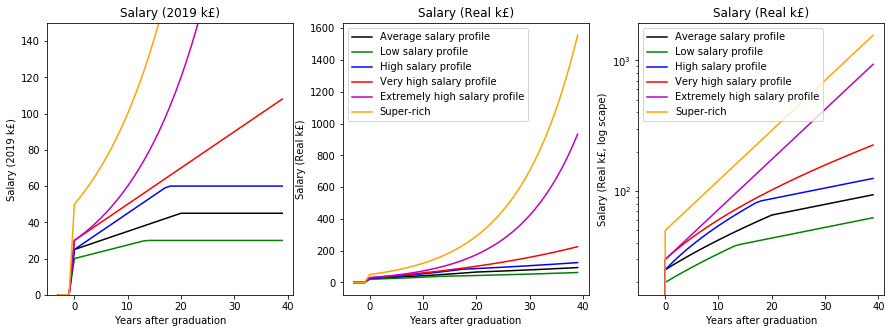

In [3]:
plot.figure(figsize=(15,5))
plot.subplot(1,3,1)
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['salary-noinf']/1e3,label=data[p]['desc'],
                  c=data[p].get('col',None),ls=data[p].get('ls','-'))
plot.title('Salary (2019 k£)')
plot.ylabel('Salary (2019 k£)')
plot.ylim(0,150)
plot.xlabel('Years after graduation')

plot.subplot(1,3,2)
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['salary']/1e3,label=data[p]['desc'],
                  c=data[p].get('col',None),ls=data[p].get('ls','-'))
plot.title('Salary (Real k£)')
plot.ylabel('Salary (Real k£)')
plot.xlabel('Years after graduation')
plot.legend()

plot.subplot(1,3,3)
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['salary']/1e3,label=data[p]['desc'],
                  c=data[p].get('col',None),ls=data[p].get('ls','-'))
plot.title('Salary (Real k£)')
plot.ylabel('Salary (Real k£, log scape)')
plot.yscale('log')
plot.xlabel('Years after graduation')
plot.legend()
plot.savefig('salary_profiles.png')

#### Description:
https://raw.githubusercontent.com/chrisnorth/loan-model/master/salary_profiles.png

**Some example salary profiles**

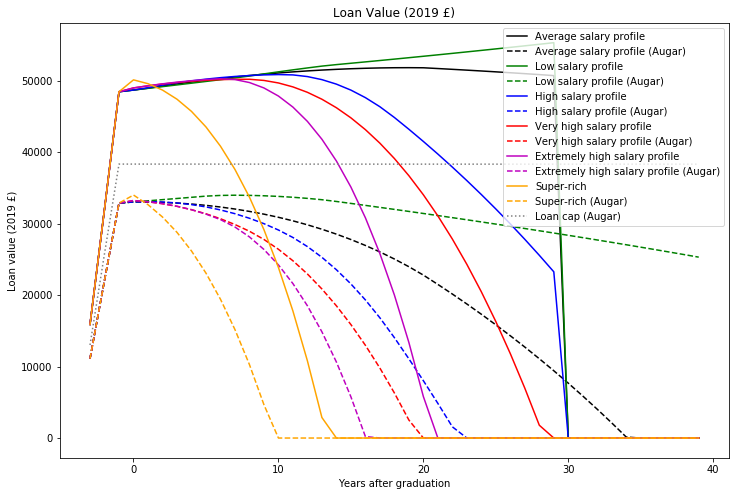

In [4]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['loan-noinf'],label=data[p]['desc'],
                  c=data[p].get('col',None),ls='-')
        plot.plot(data[p]['year'],data[p]['loan-noinf_augar'],label=data[p]['desc']+' (Augar)',
                  c=data[p].get('col',None),ls='--')
plot.plot(data[p]['year'],data[p]['maxloan-noinf_augar'],ls=':',color='gray',label='Loan cap (Augar)')
plot.title('Loan Value (2019 £)')
plot.xlabel('Years after graduation')
plot.ylabel('Loan value (2019 £)')
plot.legend()
plot.savefig('loan-value_profiles.png')

#### Description:
https://raw.githubusercontent.com/chrisnorth/loan-model/master/loan-value_profiles.png

**The more you earn, the faster you pay off your loan.**

**Post-Augar, the total loan value is lower due to lower fee and lower subsistence loan**

**The loan cap helps the lowest earners**

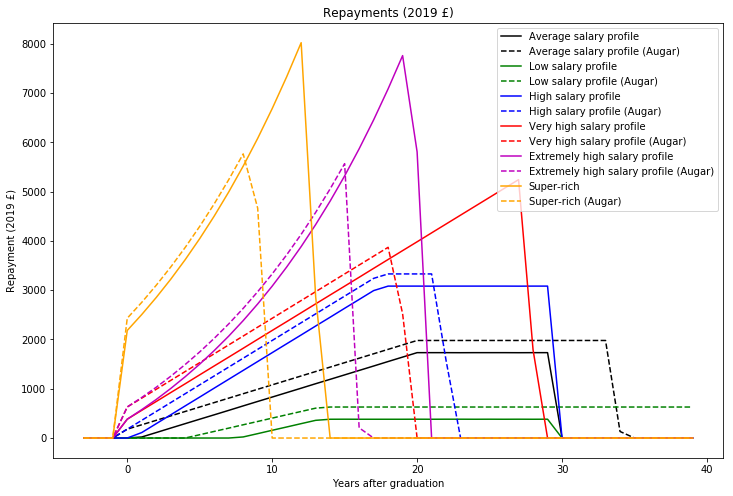

In [5]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['repayment-noinf'],label=data[p]['desc'],
                  c=data[p].get('col',None),ls='-')
        plot.plot(data[p]['year'],data[p]['repayment-noinf_augar'],label=data[p]['desc']+' (Augar)',
                  c=data[p].get('col',None),ls='--')
plot.title('Repayments (2019 £)')
plot.xlabel('Years after graduation')
plot.ylabel('Repayment (2019 £)')
plot.legend()
plot.savefig('repayments_profiles.png')

#### Description
https://raw.githubusercontent.com/chrisnorth/loan-model/master/repayments_profiles.png

**The more you earn, the more you repay***

**Under Augar, repayments are higher for all, and continue for longer for lower earners**

/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


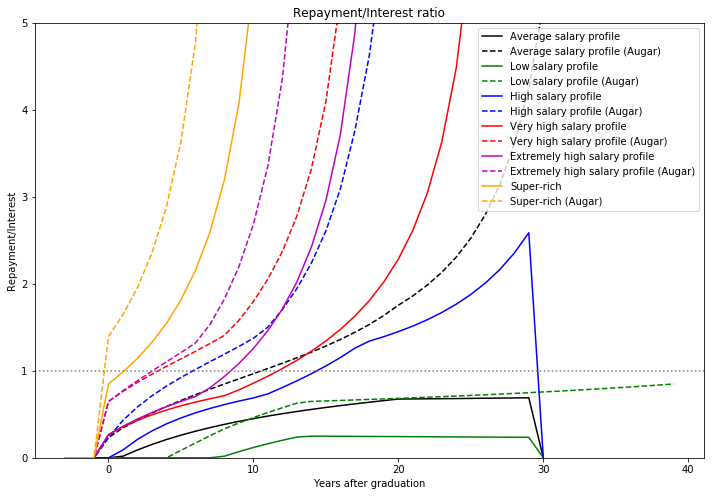

In [6]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['repayment']/data[p]['interest'],label=data[p]['desc'],
                  c=data[p].get('col',None),ls='-')
        plot.plot(data[p]['year'],data[p]['repayment_augar']/data[p]['interest_augar'],label=data[p]['desc']+' (Augar)',
                  c=data[p].get('col',None),ls='--')
plot.title('Repayment/Interest ratio')
plot.xlabel('Years after graduation')
plot.ylabel('Repayment/Interest')
plot.ylim(0,5)
plot.legend()
plot.axhline(1.0,ls=':',c='gray')
plot.savefig('loan-repay_ratio_profiles.png')

#### Description:

https://raw.githubusercontent.com/chrisnorth/loan-model/master/loan-repay_ratio_profiles.png

**The "average" profile only just starts meeting the interest after ~30 years. Low earners don't every touch the interest.**

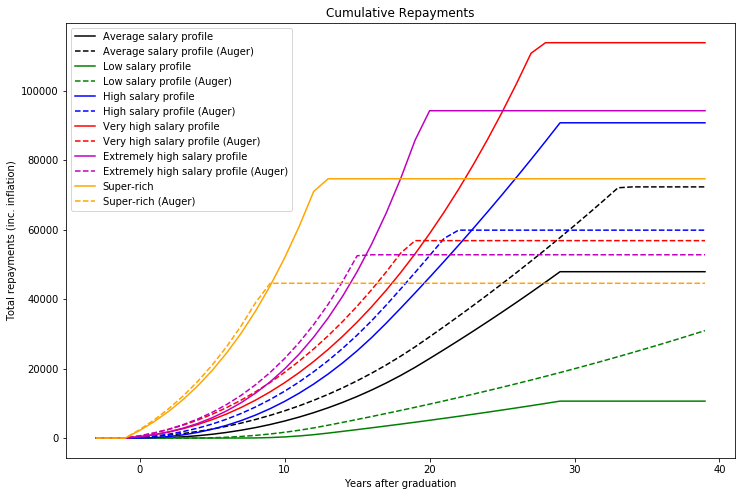

In [7]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['repayment-total'],label=data[p]['desc'],
                  c=data[p]['col'],ls='-')
        plot.plot(data[p]['year'],data[p]['repayment-total_augar'],label=data[p]['desc']+' (Auger)',
                  c=data[p]['col'],ls='--')
#     plot.plot(data[p]['year'],data[p]['interest-noinf'],label=p+' (Interest)',c=data[p]['col'],ls='--')
plot.title('Cumulative Repayments')
plot.xlabel('Years after graduation')
plot.ylabel('Total repayments (inc. inflation)')
plot.legend()
plot.savefig('cumulative_payments_profiles.png')

#### Description
https://raw.githubusercontent.com/chrisnorth/loan-model/master/cumulative_payments_profiles.png

**Currently the more you earn the more you pay in total, apart from the highest earners, who pay less**

**Those who pay the most in total post-Augar are the Average earners. Above that, the more you earn the less you pay.**

**Effect of Augar is to _increase_ total repayment for those on average or low salaries, and _decrease_ payments for those on higher salaries**

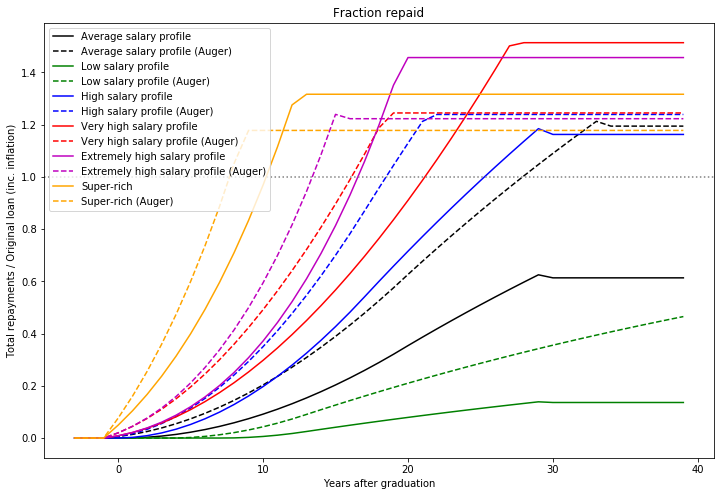

In [8]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['frac-repaid'],label=data[p]['desc'],
                  c=data[p]['col'],ls='-')
        plot.plot(data[p]['year'],data[p]['frac-repaid_augar'],label=data[p]['desc']+' (Auger)',
                  c=data[p]['col'],ls='--')
plot.axhline(1,c='gray',ls=':')
plot.title('Fraction repaid')
plot.xlabel('Years after graduation')
plot.ylabel('Total repayments / Original loan (inc. inflation)')
plot.legend()
plot.savefig('frac_repaid_profiles.png')

#### Description
https://raw.githubusercontent.com/chrisnorth/loan-model/master/frac_repaid_profiles.png

**After Auger, a greater proportion of people (i.e people on lower salaries than at present) will pay off their loan**

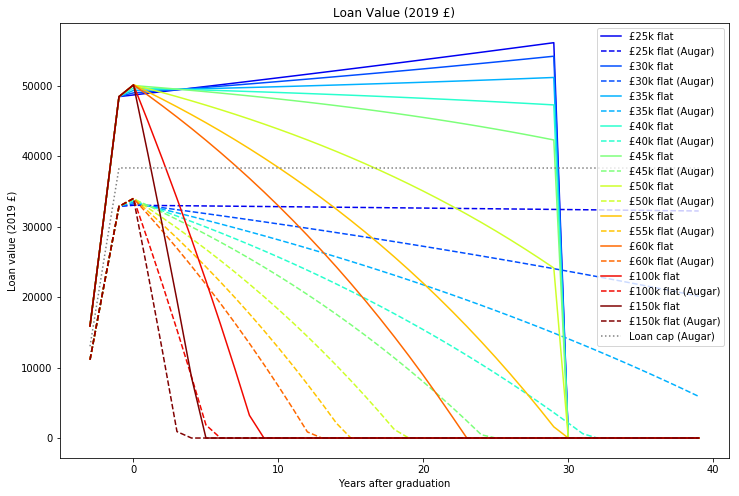

In [9]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='flat':
        plot.plot(data[p]['year'],data[p]['loan-noinf'],label=data[p]['desc'],
                  c=data[p].get('col',None),ls='-')
        plot.plot(data[p]['year'],data[p]['loan-noinf_augar'],label=data[p]['desc']+' (Augar)',
                  c=data[p].get('col',None),ls='--')
plot.plot(data[p]['year'],data[p]['maxloan-noinf_augar'],ls=':',color='gray',label='Loan cap (Augar)')
plot.title('Loan Value (2019 £)')
plot.xlabel('Years after graduation')
plot.ylabel('Loan value (2019 £)')
plot.legend()
plot.savefig('loan-value.png')

#### Description:
https://raw.githubusercontent.com/chrisnorth/loan-model/master/cumulative_payments.png

**The max loan line (grey dotted) has very little to no impact**

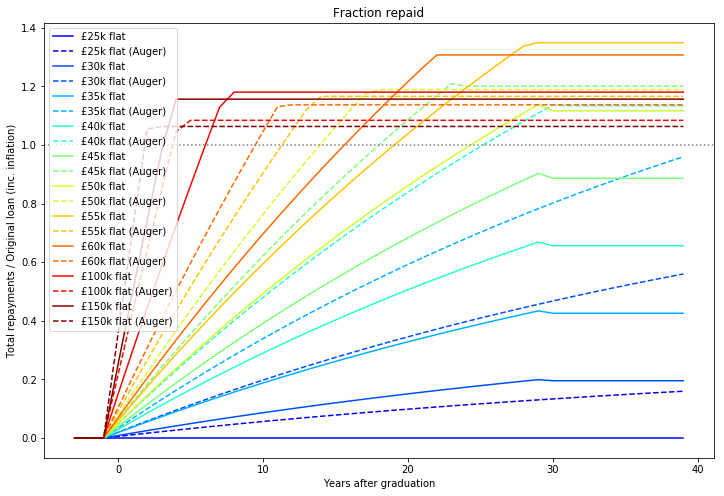

In [10]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='flat':
        plot.plot(data[p]['year'],data[p]['frac-repaid'],label=data[p]['desc'],
                  c=data[p]['col'],ls='-')
        plot.plot(data[p]['year'],data[p]['frac-repaid_augar'],label=data[p]['desc']+' (Auger)',
                  c=data[p]['col'],ls='--')
plot.axhline(1,c='gray',ls=':')
plot.title('Fraction repaid')
plot.xlabel('Years after graduation')
plot.ylabel('Total repayments / Original loan (inc. inflation)')
plot.legend()
plot.savefig('frac_repaid.png')

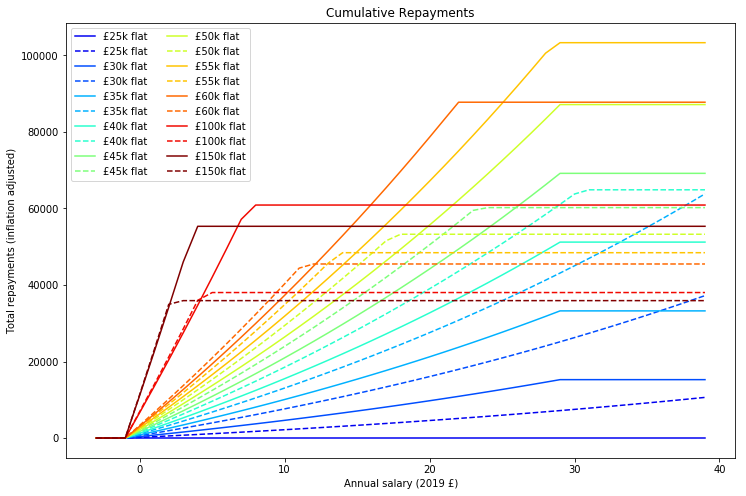

In [11]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='flat':
        plot.plot(data[p]['year'],data[p]['repayment-total'],label=data[p]['desc'],c=data[p]['col'],ls='-')
        plot.plot(data[p]['year'],data[p]['repayment-total_augar'],label=data[p]['desc'],c=data[p]['col'],ls='--')
#     plot.plot(data[p]['year'],data[p]['interest-noinf'],label=p+' (Interest)',c=data[p]['col'],ls='--')
plot.title('Cumulative Repayments')
plot.ylabel('Total repayments (inflation adjusted)')
plot.xlabel('Annual salary (2019 £)')
plot.legend(ncol=2)
plot.savefig('cumulative_payments.png')

#### Description:
https://raw.githubusercontent.com/chrisnorth/loan-model/master/cumulative_payments.png

**For flat salaries (with inflation), peak payments are for £45k. Above that, you pay less the more you earn. The turnover is effectively the point at which a graduate pays off the full loan value.**

**Augar increases total payment for low salaries, and decreases for higher salaries**

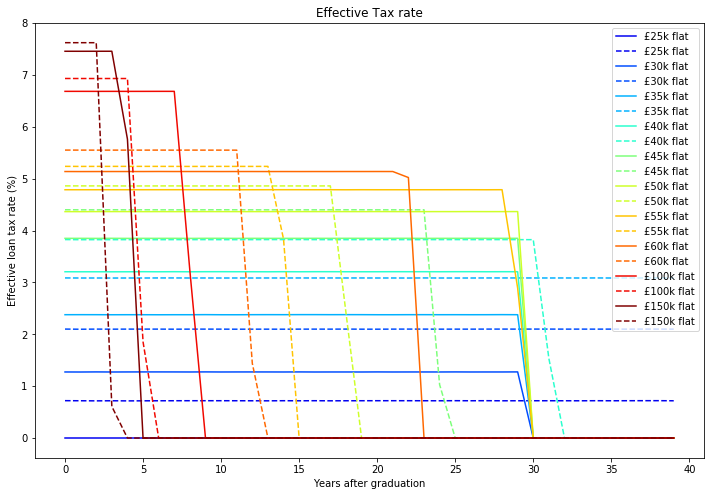

In [12]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='flat':
        plot.plot(data[p]['year'],data[p]['effectiveTax']*100,label=data[p]['desc'],c=data[p]['col'],ls='-')
        plot.plot(data[p]['year'],data[p]['effectiveTax_augar']*100,label=data[p]['desc'],c=data[p]['col'],ls='--')
#     plot.plot(data[p]['year'],data[p]['interest-noinf'],label=p+' (Interest)',c=data[p]['col'],ls='--')
plot.title('Effective Tax rate')
plot.ylabel('Effective loan tax rate (%)')
plot.xlabel('Years after graduation')
plot.legend()
plot.savefig('effective_tax.png')

#### Description
https://raw.githubusercontent.com/chrisnorth/loan-model/master/effective_tax.png

**The effective tax rate (repayment as fraction of salary) is higher the more you earn, since it only affects earnings over a certain threshold, but is paid for less time if you earn more.**

**Augar increases the effective tax rate, and extends to payment time**

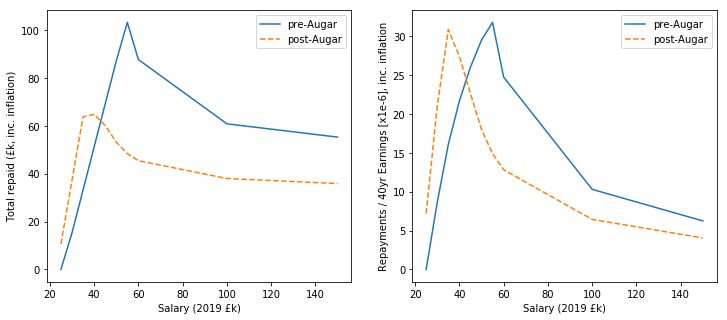

In [13]:
salaries=[]
repayments=[]
repayments_augar=[]
totalsalary=[]
fracpay=[]
for p in data:
    if data[p]['type']=='flat':
        salaries.append(data[p]['salary-noinf'][-1]/1e3)
        totalsalary.append(np.sum(data[p]['salary']))
        repayments.append(data[p]['repayment-total'][-1]/1e3)
        repayments_augar.append(data[p]['repayment-total_augar'][-1]/1e3)

plot.figure(figsize=(12,5))
plot.subplot(1,2,1)
plot.plot(salaries,repayments,ls='-',label='pre-Augar')
plot.plot(salaries,repayments_augar,ls='--',label='post-Augar')
#     plot.plot(data[p]['year'],data[p]['interest-noinf'],label=p+' (Interest)',c=data[p]['col'],ls='--')
plot.ylabel('Total repaid (£k, inc. inflation)')
plot.xlabel('Salary (2019 £k)')
plot.legend()

plot.subplot(1,2,2)
plot.plot(salaries,np.array(repayments)/np.array(totalsalary)*1e6,ls='-',label='pre-Augar')
plot.plot(salaries,np.array(repayments_augar)/np.array(totalsalary)*1e6,ls='--',label='post-Augar')
plot.ylabel('Repayments / 40yr Earnings [x1e-6], inc. inflation')
plot.xlabel('Salary (2019 £k)')
plot.legend()
plot.savefig('salary_repayments.png')


#### Description

https://raw.githubusercontent.com/chrisnorth/loan-model/master/salary_repayments.png

**Pre-Auger, above about £60k the more you earn the less you pay off, whether in terms of total amount or relative to total earnings**

**Post-Auger, the turning point is £40k**

**Earners above £45k benefit, below £45k pay**